The aim of this notebook is to improve upon the methods used in notebook 7a.

It contains:
- Loading and writing Sentinel-2 data and WorldCover data into a dataset based on region (no merging needed)
- Testing to see if that dataste was save properly

Note:
- The dataset is relatively small, so I can test it easily
- This notebook Works with 8b, **not 8a** as they use incompatible data saving/loading techniques



In [5]:
# Common imports and settings
import os, sys, re
from pathlib import Path
from IPython.display import Markdown
import pandas as pd
pd.set_option("display.max_rows", None)
import xarray as xr
import dask
from dask.distributed import Client
from dask_gateway import Gateway
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta
import numpy as np
# Datacube
import datacube
from datacube.utils.aws import configure_s3_access
import odc.geo.xr                                  # https://github.com/opendatacube/odc-geo
from datacube.utils import masking  # https://github.com/opendatacube/datacube-core/blob/develop/datacube/utils/masking.py
from odc.algo import enum_to_bool                  # https://github.com/opendatacube/odc-tools/blob/develop/libs/algo/odc/algo/_masking.py
from dea_tools.plotting import display_map, rgb    # https://github.com/GeoscienceAustralia/dea-notebooks/tree/develop/Tools
import s3fs
import boto3

# Basic plots
%matplotlib inline
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [12, 8]

# Holoviews
# https://holoviz.org/tutorial/Composing_Plots.html
# https://holoviews.org/user_guide/Composing_Elements.html
import hvplot.pandas
import hvplot.xarray
import panel as pn
import colorcet as cc
import cartopy.crs as ccrs
from datashader import reductions
from holoviews import opts
# hv.extension('bokeh', logo=False)
print("Libraries loaded successfully.")

Libraries loaded successfully.


In [16]:
# EASI defaults
# These are convenience functions so that the notebooks in this repository work in all EASI deployments

# The `git.Repo()` part returns the local directory that easi-notebooks has been cloned into
# If using the `easi-tools` functions from another path, replace `repo` with your local path to `easi-notebooks` directory
try:
    import git
    repo = git.Repo('.', search_parent_directories=True).working_tree_dir    # Path to this cloned local directory
except (ImportError, git.InvalidGitRepositoryError):
    repo = Path.home() / 'easi-notebooks'    # Reasonable default
    if not repo.is_dir():
        raise RuntimeError('To use `easi-tools` please provide the local path to `https://github.com/csiro-easi/easi-notebooks`')
if repo not in sys.path:
    sys.path.append(str(repo))    # Add the local path to `easi-notebooks` to python

from easi_tools import EasiDefaults
from easi_tools import initialize_dask, xarray_object_size, mostcommon_crs, heading
#from easi_tools.load_s2l2a import load_s2l2a_with_offset
print("EASI librariies loaded successfully.")

EASI librariies loaded successfully.


In [17]:
from easi_tools.dask_helpers import (
    load_config,
    spec_from_config,
    make_catalog,
    GridRegionSampler,
    STACIceChunkBuilder,
    verify_icechunk_dataset
)

from easi_tools.dask_training import (
    GeoBatchSpec,
    BatchAdapter,
    get_num_samples,
    make_dali_iterator,
    train_one_epoch,
    evaluate,
    SegmentationTask,
    wrap_model_with_fsdp,
    train_one_epoch_log,
    WorldCoverLabelMapper,
    load_latest_training_log,
    test_model,
    inspect_timing
)

print("EASI tools loaded successfully")

EASI tools loaded successfully


# Dask Setup

In [8]:
gateway = Gateway()
options = gateway.cluster_options()
# To get GPUs you must specify
#options.cuda_worker = True
clusters = gateway.list_clusters()
if not clusters:
    print('Creating new cluster...')
    cluster = gateway.new_cluster(cluster_options=options)
else:
    print(f'Connecting to existing cluster: {clusters[0].name}')
    cluster = gateway.connect(clusters[0].name)

NUM_WORKERS = 2
cluster.scale(NUM_WORKERS)
client = cluster.get_client()

print("Cluster Dashboard:", client.dashboard_link)

Creating new cluster...
Cluster Dashboard: https://hub.csiro.easi-eo.solutions/services/dask-gateway/clusters/easihub.ebc88fd2134e40b2a0713b9845a96959/status


In [8]:
# Configure your cluster to use S3
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client);

This implimentation uses `ice-chunk`, if `ice-chunk` is not on your worker image you need to install it on them. The easi helper library also has a few dependancies not on the default image.

In [9]:


print("Installing icechunk (and zarr>=3) on all workers...")
client.run(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'zarr>=3.0.8', 'icechunk'])"
))

print("Installing icechunk (and zarr>=3) on the Scheduler...")
client.run_on_scheduler(lambda: exec(
    "import sys, subprocess; "
    "subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'zarr>=3.0.8', 'icechunk'])"
))

print("Installation initiated on both Scheduler and Workers. Now retry the Icechunk build.")


Installing dask-pytorch-ddp on all workers...
Installing dask-pytorch-ddp on the Scheduler...
Installing icechunk (and zarr>=3) on all workers...
Installing icechunk (and zarr>=3) on the Scheduler...
Installing Dali on all workers...
Installing Dali on the Scheduler...
Libraries installed on workers


# Data Prep
We will use the s3 bucket spcified linked to my EASI acount for storing the data.

In [13]:
# === S3 SETUP ===
easi = EasiDefaults()
bucket = easi.scratch
userid = boto3.client('sts').get_caller_identity()['UserId']
project_name = "training_test_project"
base_prefix = f"{userid}/{project_name}"
s3_base = f"s3://{bucket}/{base_prefix}"

Successfully found configuration for deployment "csiro"


## Data Selection
Here we Specify:
- Regions to Select the data from
- What Label dataset we will be using (in this case World Cover)

In [14]:
cfg = load_config("./Argo_Files/training_dataset.json")
spec = spec_from_config(cfg)
catalog = make_catalog(cfg)

print("Data setup done")

Data setup done


## Processing Individual Locations
By using Ice Chunk we can continuously write in a single session. 
This large dataset will contain:
- Train data
- Validation data

We can do a seperate data call for the test dataset later when evaluating.

The Prithvi model we are using prefers everything in 224x224 patches so we will load in a large patches, break them down into 224x224 and save them into the dataset.

## Combining the Datasets
Once we have all the data saved and loaded we can combine them into once cmplete dataset

In [15]:
print("Building incremental Icechunk dataset...")

sampler = GridRegionSampler(tile_size=224)

# Choose a logical dataset name (no need for .zarr suffix)
dataset_name = "training_dataset_v4"

builder = STACIceChunkBuilder(
    catalog=catalog,
    bucket=bucket,
    base_prefix=base_prefix,
    dataset_name=dataset_name,
    spec=spec,
    sampler=sampler,
)

snapshot_id = builder.build(branch="main", resume=True)
print("Snapshot ID:", snapshot_id)

# For later use in training:
print("Repo prefix:", builder.repo_prefix)   # e.g. f"{base_prefix}/{dataset_name}-icechunk"

Building incremental Icechunk dataset...
[resume] Found existing dataset on 'main': 627 samples, 30 regions_done.
  Region tasmania_forest_c already present, skipping.
  Region tasmania_forest_w already present, skipping.
  Region tasmania_forest_e already present, skipping.
  Region tasmania_forest_s already present, skipping.
  Region vic_agriculture_c already present, skipping.
  Region vic_agriculture_w already present, skipping.
  Region vic_agriculture_e already present, skipping.
  Region vic_agriculture_n already present, skipping.
  Region vic_agriculture_s already present, skipping.
  Region nsw_coast_c already present, skipping.
  Region nsw_coast_n already present, skipping.
  Region nsw_coast_s already present, skipping.
  Region nsw_coast_w already present, skipping.
  Region nsw_coast_e already present, skipping.
  Region qld_tropical_c already present, skipping.
  Region qld_tropical_n already present, skipping.
  Region qld_tropical_s already present, skipping.
  Regio

#### Optional Step (1)
If you just want to delete everything you can so doing this

In [14]:

fs = s3fs.S3FileSystem(anon=False)

# Full S3 path to the Icechunk repo prefix
icechunk_prefix = f"s3://{bucket}/{builder.repo_prefix}"

print("Deleting Icechunk repo prefix:", icechunk_prefix)
fs.rm(icechunk_prefix, recursive=True)

Deleting Icechunk repo prefix: s3://easihub-csiro-user-scratch/AROAWO7MSC2T2SINGSYOQ:csiro-csiro-aad_gre555@csiro.au/training_test_project/training_dataset_v4-icechunk


[]

#### Optional Step (2)
You can check the data format and if everything was saved correctly by graphing a few samples locally.
You should check:
- Demensions of the dataset (sample: 627, band: 6, time: 3, y: 224, x: 224)
  - bands, x and y should match the model input you are using (For prithvi 6 bands, and 224x224 patches)
- Label Dimensions and Values
  - Dimensions should match the 224x224 patches
  - Values of WorldCover should not contain NaN and be multiples of 10 from 10 to 100 or 95
  - This is also a sanity check to see if your labels line up with the ESI patches spatially 



⏳ Verifying Icechunk-backed dataset...
✅ Dataset loaded. Dimensions:
  Samples (N): 627
  Time Steps (T): 3
  Spatial (Y, X): 224, 224
  Bands: ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
DEBUG: Sample 0 unique label values: [10 30 60 80 90]
DEBUG: Sample 1 unique label values: [10 30 60 80 90]


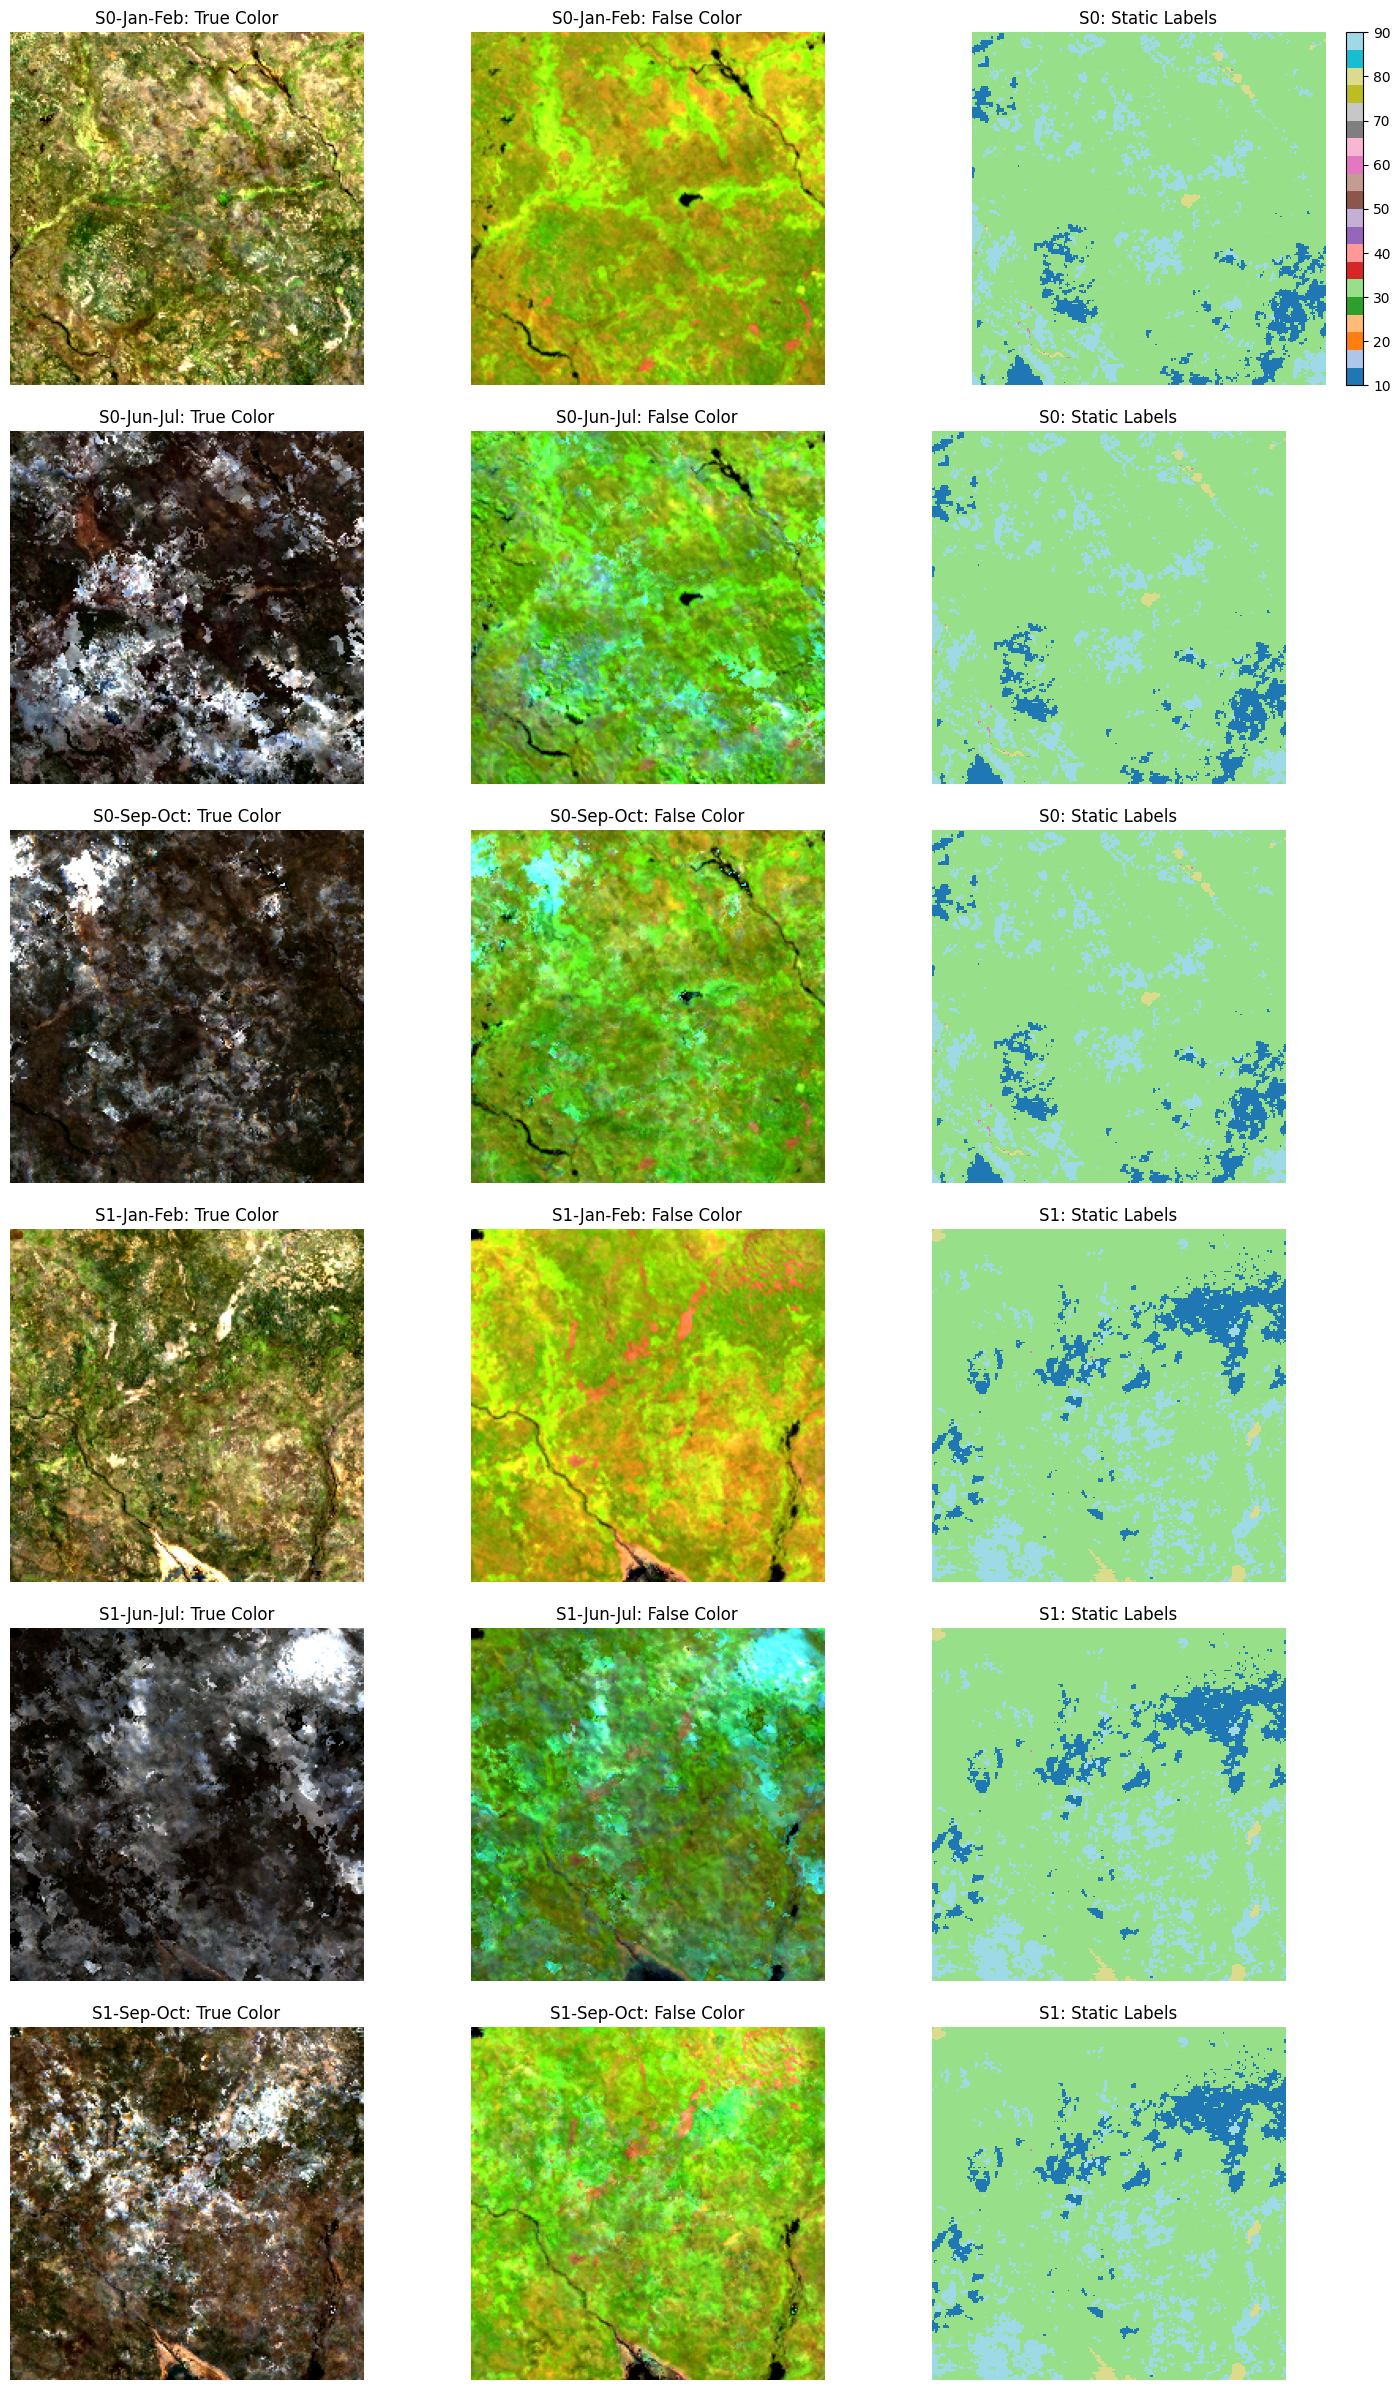

In [17]:
from ice_chunk_writer import verify_icechunk_dataset

ds = verify_icechunk_dataset(
    bucket=bucket,
    repo_prefix=builder.repo_prefix,
    branch="main",
    max_samples=2,
    make_plots=True,
)

# Test Datasets
We can also do the same thing to make a test dataset. It is easier to have the dataset seperate as Dask workers won't need it while training.

In [18]:
cfg = load_config("./Argo_Files/test_dataset.json")
test_spec = spec_from_config(cfg)
catalog = make_catalog(cfg)

print("Data setup done")

Data setup done


In [ ]:


test_builder = STACIceChunkBuilder(
    catalog=catalog,
    bucket=bucket,
    base_prefix=base_prefix,
    dataset_name="training_dataset_v4_test",
    spec=test_spec,
    sampler=sampler,
)

test_snapshot_id = test_builder.build(branch="main", resume=True)
test_repo_prefix = test_builder.repo_prefix
print("Test Snapshot_id: " + test_snapshot_id)
print("Test Repo Prefix: " + test_repo_prefix)

[resume] No readable dataset found on 'main' (will start fresh). Reason: GroupNotFoundError: No group found in store <icechunk.store.IcechunkStore object at 0x7fe35e701d90> at path ''

=== Building patches for test_tasmania_forest_e2 ===
  STAC search start (try 1/3) ['esa-worldcover'] None bbox=(147.1, -42.3, 147.3, -42.1)
  STAC search start (try 1/3) ['sentinel-2-l2a'] 2021-01-01/2021-02-28 bbox=(147.1, -42.3, 147.3, -42.1)
  STAC search start (try 1/3) ['sentinel-2-l2a'] 2021-06-01/2021-07-31 bbox=(147.1, -42.3, 147.3, -42.1)
  STAC search start (try 1/3) ['sentinel-2-l2a'] 2021-09-01/2021-10-31 bbox=(147.1, -42.3, 147.3, -42.1)
  Writing 20 samples from test_tasmania_forest_e2

=== Building patches for test_vic_agriculture_e2 ===
  STAC search start (try 1/3) ['esa-worldcover'] None bbox=(144.1, -36.7, 144.3, -36.5)
  STAC search start (try 1/3) ['sentinel-2-l2a'] 2021-01-01/2021-02-28 bbox=(144.1, -36.7, 144.3, -36.5)
  STAC search start (try 1/3) ['sentinel-2-l2a'] 2021-06-01/20

# Be a good Dask user and close your cluster when you are done

In [ ]:
client.close()
cluster.shutdown()